In [1]:
!mkdir /Users/nizheng/Desktop/Study/STAT\ 479/project
!mkdir /Users/nizheng/Desktop/Study/STAT\ 479/project/models
!cp /Users/nizheng/Downloads/keras-pretrained-models/*notop* /Users/nizheng/Desktop/Study/STAT\ 479/project/models/
!cp /Users/nizheng/Downloads/keras-pretrained-models/imagenet_class_index.json /Users/nizheng/Desktop/Study/STAT\ 479/project/models/
!cp /Users/nizheng/Downloads/keras-pretrained-models/resnet50* /Users/nizheng/Desktop/Study/STAT\ 479/project/models/

mkdir: /Users/nizheng/Desktop/Study/STAT 479/project: File exists
mkdir: /Users/nizheng/Desktop/Study/STAT 479/project/models: File exists


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

/Users/nizheng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.chdir("/Users/nizheng/Desktop/Study/STAT 479/project")

In [4]:
base_h5 = os.path.join('/Users/nizheng/Desktop' ,'mias-mammography', 'all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
291,D,NORM,NaN,mdb284,nan,NaN,NaN,mdb284.pgm,tiffs/mdb284.tif
1,G,CIRC,69.0,mdb002,B,522.0,280.0,mdb002.pgm,tiffs/mdb002.tif
274,F,MISC,56.0,mdb267,M,793.0,481.0,mdb267.pgm,tiffs/mdb267.tif
110,D,ASYM,51.0,mdb110,M,190.0,427.0,mdb110.pgm,tiffs/mdb110.tif
49,G,NORM,NaN,mdb049,nan,NaN,NaN,mdb049.pgm,tiffs/mdb049.tif


Using TensorFlow backend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x82682f710>,
      dtype=object)

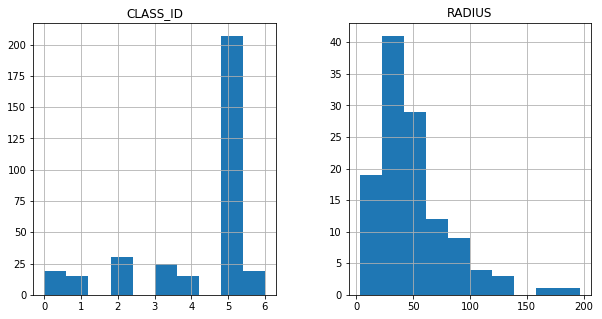

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

In [7]:
#split data into train and validation
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
303,D,NORM,NaN,mdb296,nan,NaN,NaN,mdb296.pgm,tiffs/mdb296.tif,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


New Data Size: 1300 Old Size: 247


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x826aca438>,
      dtype=object)

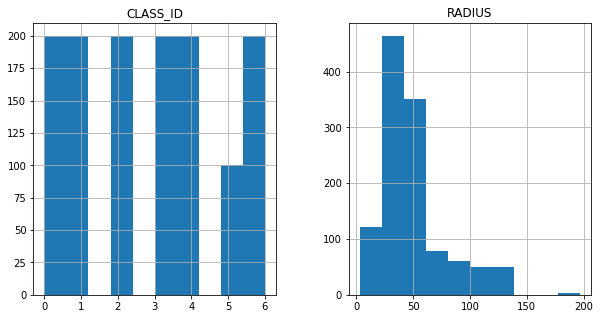

In [8]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (192, 192) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [14]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [15]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images


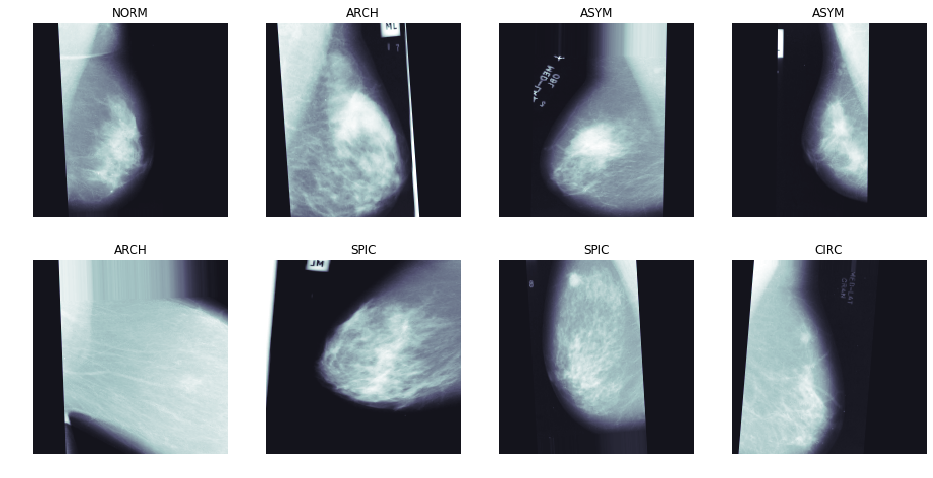

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % (class_enc.classes_[np.argmax(c_y,-1)]))
    c_ax.axis('off')

In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(len(class_enc.classes_), activation = 'softmax')(dr_steps) # linear is what 16bit did
mammo_model = Model(inputs = [in_lay], outputs = [out_layer])

mammo_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

mammo_model.summary()

58892288/58889256 [==============================] - 6s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 6, 6, 512)    14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 6, 6, 512)    2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 64)     32832       batch_normalization_1[0][0]      
____________________________________________

In [115]:
#!rm -rf /Users/nizheng/Desktop/Study/STAT\ 479/project # clean up the model / make space for other things

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('mammo_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [17]:
mammo_model.fit_generator(train_gen,
                          steps_per_epoch=35,
                          validation_data=(test_X,test_Y),
                          epochs=5,
                          callbacks=callbacks_list)

Epoch 1/5
35/35 [==============================] - 381s 11s/step - loss: 1.8070 - categorical_accuracy: 0.2964 - val_loss: 2.1214 - val_categorical_accuracy: 0.2410

Epoch 00001: val_loss improved from inf to 2.12143, saving model to mammo_result_weights.best.hdf5
Epoch 2/5
35/35 [==============================] - 373s 11s/step - loss: 1.3926 - categorical_accuracy: 0.5058 - val_loss: 2.2561 - val_categorical_accuracy: 0.1928

Epoch 00002: val_loss did not improve from 2.12143
Epoch 3/5
35/35 [==============================] - 372s 11s/step - loss: 1.1934 - categorical_accuracy: 0.6057 - val_loss: 2.2142 - val_categorical_accuracy: 0.2048

Epoch 00003: val_loss did not improve from 2.12143
Epoch 4/5
35/35 [==============================] - 1556s 44s/step - loss: 1.0413 - categorical_accuracy: 0.6540 - val_loss: 2.2327 - val_categorical_accuracy: 0.2169

Epoch 00004: val_loss did not improve from 2.12143
Epoch 5/5
35/35 [==============================] - 389s 11s/step - loss: 0.9426 - c

In [18]:
mammo_model.load_weights(weight_path)

In [19]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in mammo_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

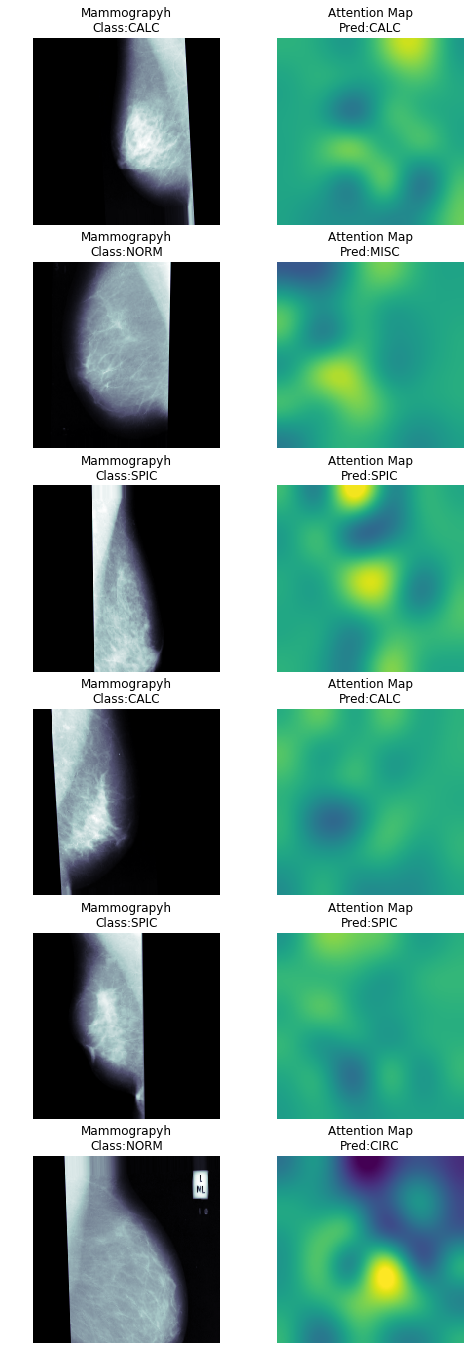

In [20]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [mammo_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_label = class_enc.classes_[np.argmax(test_Y[c_idx])]
    img_ax.set_title('Mammograpyh\nClass:%s' % (real_label))
    pred_confidence = class_enc.classes_[np.argmax(mammo_model.predict(cur_img)[0],-1)]
    attn_ax.set_title('Attention Map\nPred:%s' % (pred_confidence))
fig.savefig('attention_map.png', dpi = 300)

In [21]:
pred_Y = mammo_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
test_Y_cat = np.argmax(test_Y, -1)

83/83 [==============================] - 25s 306ms/step


In [22]:
print(test_Y_cat,"\n",pred_Y_cat)
np.argmax(pred_Y[2],-1)
test_Y

[5 6 3 5 5 3 5 6 2 5 2 5 2 2 5 5 6 5 5 5 5 5 5 5 3 5 4 6 2 1 5 5 5 2 5 5 5
 5 3 5 2 5 5 5 1 5 5 2 1 0 5 5 4 5 5 5 5 5 5 5 6 3 5 0 5 0 5 0 0 5 5 5 4 5
 5 5 3 5 5 5 4 5 5] 
 [4 6 6 2 6 2 4 6 2 2 6 2 2 2 6 3 6 0 2 4 4 2 2 4 3 2 4 2 2 2 6 2 4 2 4 1 6
 2 3 4 2 1 2 3 1 6 2 2 2 6 2 5 0 0 6 6 0 1 2 0 6 3 3 0 4 0 6 1 3 2 6 2 4 0
 0 2 4 4 0 3 3 2 6]


array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
 

             precision    recall  f1-score   support

       ARCH       0.20      0.40      0.27         5
       ASYM       0.20      0.33      0.25         3
       CALC       0.25      0.88      0.39         8
       CIRC       0.33      0.50      0.40         6
       MISC       0.15      0.50      0.24         4
       NORM       1.00      0.02      0.04        52
       SPIC       0.24      0.80      0.36         5

avg / total       0.72      0.24      0.15        83



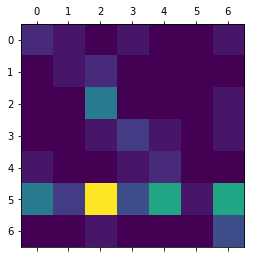

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y_cat, pred_Y_cat))
print(classification_report(test_Y_cat, pred_Y_cat, target_names = class_enc.classes_))